In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions

# !git clone 'https://github.com/facebookresearch/detectron2'

dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/setuptools/config/setupcfg.py:293: _DeprecatedConfig: Deprecated config in `setup.cfg`
      !!
      
              ********************************************************************************
              The license_file parameter is deprecated, use license_files instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
        parsed = self.parsers.get(option_name,

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.1.1+cu121 False


In [3]:
import os
os.chdir('object_detection/detectron_2')

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from tqdm import tqdm
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

matplotlib data path: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/mpl-data
CONFIGDIR=/teamspace/studios/this_studio/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/teamspace/studios/this_studio/.cache/matplotlib
Using fontManager instance from /teamspace/studios/this_studio/.cache/matplotlib/fontlist-v330.json


In [5]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

# Moving images to the separate folder

Images of each class were saved in a separate folder:

```
train/
    Bicycle/
    Boat/
validation/
    Bicycle/
    Boat/
```

Because we already have annotation files which have information about train/val split and classes, we can put all images into the same folder for easier processing.

```bash
# Move images in subfolders to one folder
for folder in ['train', 'validation']:
    !mkdir -p images
    !mv $folder/Bicycle/* images
    !rmdir $folder/Bicycle
    !mv $folder/Boat/* images
    !rmdir $folder/Boat
```

In [6]:
# Specify target classes and create `class2id` dict
target_classes = ['Bicycle', 'Boat']
class_to_id = {k: v for v, k in enumerate(target_classes)}
print(class_to_id)

# Get LabelName of target classes
class_des_csv_path = "/teamspace/studios/this_studio/object_detection/raw_data/OI_v5/class-descriptions-boxable.csv"

classes = pd.read_csv(class_des_csv_path, header=None, names=['LabelName', 'Class'])
subset_classes = classes[classes['Class'].isin(target_classes)]
subset_classes

{'Bicycle': 0, 'Boat': 1}


,LabelName,Class
39,/m/0199g,Bicycle
42,/m/019jd,Boat


In [7]:
ROOT_PATH = "/teamspace/studios/this_studio/object_detection/raw_data/OI_v5/"
# Prepare annotation files
for folder in ['train', 'validation']:
    # Load data
    annot_df = pd.read_csv(f"{ROOT_PATH}/{folder}-annotations-bbox.csv")
    # Inner join to keep only target classes
    annot_df = annot_df.merge(subset_classes, on='LabelName')
    # Create `ClassID` column
    annot_df['ClassID'] = annot_df['Class'].apply(lambda x: class_to_id[x])
    # Save truncated annot_df
    annot_df.to_csv(f"{ROOT_PATH}/{folder}-annotations-bbox-truncated.csv", index=False)
    del annot_df

Function `get_detectron_dicts` takes an annotation dataframe and returns a `list[dict]` to register and load Detectron2 dataset.

In [16]:
def denormalize_bboxes(bboxes, height, width):
    """Denormalize bounding boxes in format of (xmin, ymin, xmax, ymax)."""
    bboxes[:, [0, 2]] = bboxes[:, [0, 2]] * width
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]] * height
    return np.round(bboxes)

def get_detectron_dicts(annot_df, mode):
    """
    Create Detectron2's standard dataset from an annotation file.
    
    Args:
        annot_df (pd.DataFrame): annotation dataframe.
    Return:
        dataset_dicts (list[dict]): List of annotation dictionaries for Detectron2.
    """
    
    # Get image ids
    img_ids = annot_df["ImageID"].unique().tolist()
    
    FILE_PATH = f"/teamspace/studios/this_studio/object_detection/raw_data/OI_v5/{mode}"
    dataset_dicts = []
    
    for cls in target_classes:
        for img_id in tqdm(img_ids):
            file_name = f'{FILE_PATH}/{cls}/{img_id}.jpg'
            if not os.path.exists(file_name):
                print(f"File not present: {file_name}")
                continue
                
            height, width = cv2.imread(file_name).shape[:2]
                
            record = {}
            record['file_name'] = file_name
            record['image_id'] = img_id
            record['height'] = height
            record['width'] = width
            
            # Extract bboxes from annotation file
            bboxes = annot_df[['XMin', 'YMin', 'XMax', 'YMax']][annot_df['ImageID'] == img_id].values
            bboxes = denormalize_bboxes(bboxes, height, width)
            class_ids = annot_df[['ClassID']][annot_df['ImageID'] == img_id].values
            
            annots = []
            for i, bbox in enumerate(bboxes.tolist()):
                annot = {
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": int(class_ids[i]),
                }
                annots.append(annot)

            record["annotations"] = annots
            dataset_dicts.append(record)
            
    return dataset_dicts

# Registering Data

In [9]:
target_classes

['Bicycle', 'Boat']

In [10]:
# Load subset annotations
train_df = pd.read_csv("/teamspace/studios/this_studio/object_detection/raw_data/OI_v5/train-annotations-bbox-truncated.csv")
val_df = pd.read_csv("/teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation-annotations-bbox-truncated.csv")

# Register dataset with Detectron2
DatasetCatalog.register("bicycle_boat_train", lambda d: get_detectron_dicts(train_df))
MetadataCatalog.get("bicycle_boat_train").set(thing_classes=target_classes)
DatasetCatalog.register("bicycle_boat_val", lambda d: get_detectron_dicts(val_df))
MetadataCatalog.get("bicycle_boat_val").set(thing_classes=target_classes)

# Get metadata. It helps show class labels when we visualize bounding boxes
bicycle_boat_metadata = MetadataCatalog.get("bicycle_boat_train")

In [18]:
dataset_dicts = get_detectron_dicts(val_df, mode='validation')
dataset_dicts[0]

  0%|          | 0/818 [00:00<?, ?it/s]/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of 

File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/0081f359f925712e.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/008216e31b1aecf0.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/0089b8f6212315ec.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/0189d61b2c1df778.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/0197df7725980004.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/01bf00da5f94e942.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/0210e5bd37398d59.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/02121a19fc3a6e63.jpg
File not present: /teamspace/stu

  0%|          | 0/818 [00:00<?, ?it/s]/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of 

File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Boat/00575b9132bb3746.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Boat/00e9084d1bc8e0ea.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Boat/020feca9b536f1fe.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Boat/049b2fae5ca8aa8b.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Boat/0501cc6b559cc711.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Boat/06070528d72660ea.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Boat/0614bb3e0a552a9f.jpg
File not present: /teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Boat/0649557c211985bd.jpg
File not present: /teamspace/studios/this_studio/object_

/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "category_id": int(class_ids[i]),
/tmp/ipykernel_12686/3898567874.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is d

{'file_name': '/teamspace/studios/this_studio/object_detection/raw_data/OI_v5/validation/Bicycle/00575b9132bb3746.jpg',
 'image_id': '00575b9132bb3746',
 'height': 683,
 'width': 1024,
 'annotations': [{'bbox': [0.0, 0.0, 521.0, 465.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}]}

# Visualization

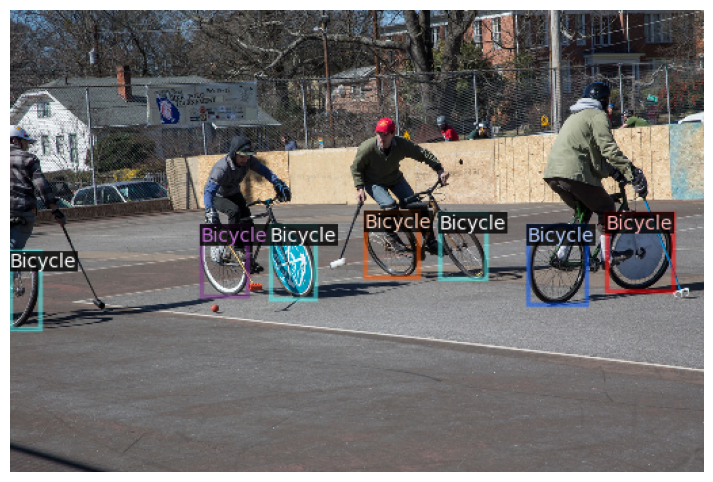

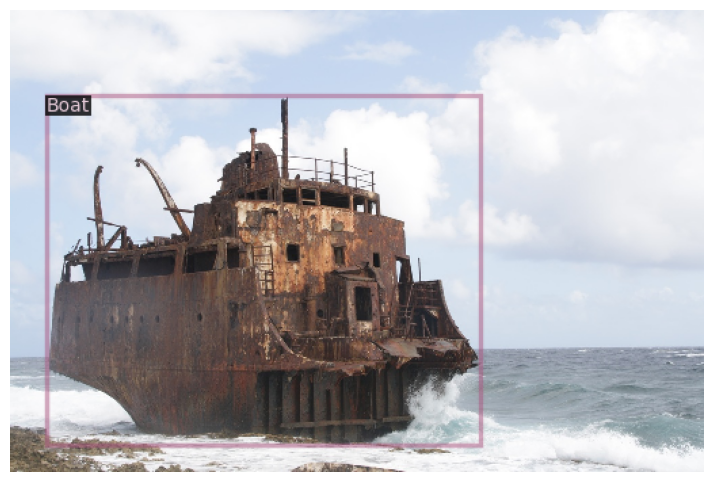

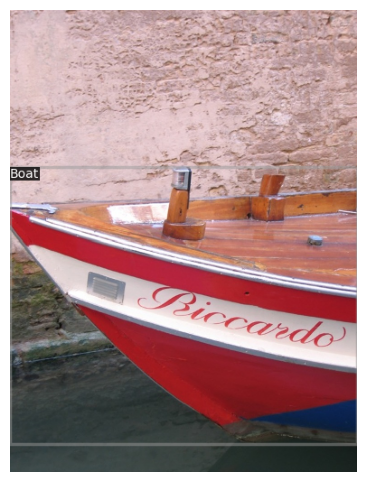

In [22]:
for d in random.sample(dataset_dicts, 3):
    plt.figure()
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=bicycle_boat_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])